<a href="https://colab.research.google.com/github/dldisha/TSS21_Machine_Learning/blob/main/HW9_UnsupervisedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: the state of machine learning and data science

Summer 2021

**Attribution**: this notebook is modeled after similar work by [Paige Bailey](https://twitter.com/DynamicWebPaige/status/1406250082194841601).

* **Name**: 
* **Net ID**: 

Now that we're wrapping up our survey of machine learning, you may be wondering what to do next. What are machine learning engineers and data scientists currently most excited about? What software frameworks and tools do they want to try out? Where are they going to learn new things?

Of course, if you ask different people these questions, you'll get many different answers. Or, if you ask 20,000 people, you'll get 20,000 different answers…

In this notebook, we'll work with the 2020 Kaggle Machine Learning & Data Science Survey.  Kaggle is an online community for machine learning and data science enthusiasts to find and share data sets and models. In their annual survey, they ask their users to answer questions about how they use machine learning and what they are looking forward to doing next.

The survey results can potentially give us some insight into what's next in machine learning.

Of course, you could just look at the most common answers to each question and stop there! But, that won't give us the full picture. We expect that there may be "cohorts" among Kaggle users who have different interests or different background: for example, there might be some respondents who use machine learning mainly for business analytics, some who use it as a hobby, some who are students, etc. Among different "cohorts", the most popular tools and techniques are likely to be different. 

Depending on which "cohort" you identify with most closely, the overall most common answers may not be very useful to you - you may be more interested in what other members of "your cohort" are doing and anticipating.

In this notebook, we will use unsupervised learning methods to try and find that underlying "cohort" structure in the data, and use it to gain insight into the state of machine learning and data science.

## Load and install libraries

We'll start by loading some familiar libraries:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import ipywidgets as widgets
from mpl_toolkits import mplot3d
from matplotlib import cm, colors
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

We'll also install a new library that's not pre-installed in Colab. This UMAP library will implement a dimensionality reduction method that we'll use later in the notebook:

In [ ]:
!pip install umap-learn

In [ ]:
from umap import UMAP

## Read in and process data


First, download the data and the survey documentation:

* [Kaggle 2020 survey data](https://drive.google.com/file/d/1fGNDBlpziYMAVHSXQJpcLd_AhrsFkVf3/view?usp=sharing)
* [Kaggle 2020 survey questions and answer options](https://drive.google.com/file/d/1yVsd9r1E6s6qh6n5UYlLxs8mKSl5VMzC/view?usp=sharing)
* [Kaggle 2020 methodology](https://drive.google.com/file/d/1Babng7-Ivfnf34jy5k6jdR8LAFxZuTgo/view?usp=sharing)

Review the survey questions and the answer options for each question.

Upload the survey data (CSV file) to your Colab workspace:

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle_survey_2020_responses.csv to kaggle_survey_2020_responses (1).csv
User uploaded file "kaggle_survey_2020_responses.csv" with length 25431748 bytes


The CSV file has two header rows - one with a question number, and one with the question text. We'll read the question text into one data frame, and the responses into another data frame.


In [ ]:
questions = pd.read_csv('kaggle_survey_2020_responses.csv', header=[0], nrows=1)
questions

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,...,Q31_B_Part_7,Q31_B_Part_8,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming language would you recommend ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool.

In [ ]:
responses = pd.read_csv('kaggle_survey_2020_responses.csv', header=[0], skiprows=[1])
responses

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,...,Q31_B_Part_7,Q31_B_Part_8,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
0,1838,35-39,Man,Colombia,Doctoral degree,Student,5-10 years,Python,R,SQL,C,NaN,NaN,Javascript,NaN,NaN,NaN,MATLAB,NaN,Other,Python,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",NaN,NaN,Visual Studio Code (VSCode),NaN,Spyder,NaN,NaN,NaN,NaN,NaN,NaN,Kaggle Notebooks,Colab Notebooks,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,SAP Analytics Cloud,NaN,NaN,"Automated data augmentation (e.g. imgaug, albu...",NaN,NaN,NaN,Automated hyperparameter tuning (e.g. hyperopt...,Automation of full ML pipelines (e.g. Google C...,NaN,NaN,Google Cloud AutoML,NaN,Databricks AutoML,NaN,NaN,Auto-Keras,Auto-Sklearn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN
1,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Python,NaN,NaN,Visual Studio,NaN,PyCharm,NaN,NaN,Sublime Text,NaN,NaN,NaN,NaN,NaN,Colab Notebooks,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,NaN,NaN,Java,Javascript,NaN,NaN,Bash,NaN,NaN,NaN,R,NaN,NaN,NaN,Visual Studio Code (VSCode),NaN,NaN,Notepad++,Sublime Text,Vim / Emacs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
3,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,NaN,Bash,NaN,NaN,NaN,Python,NaN,NaN,NaN,NaN,PyCharm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,78,30-34,Man,Japan,Master’s degree,Software Engineer,3-5 years,Python,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Python,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20031,126,18-21,Man,Turkey,Some college/university study without earning ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20032,566,55-59,Woman,United Kingdom of Great Britain and Northern I...,Master’s degree,Current

We're going to focus specifically on answers to machine learning-related questions, and exclude demographic information. Also, to make it easier, we'll just use the columns that are already essentially one-hot encoded.

So, we will drop the following columns from the data:

In [ ]:
drop_cols = ['Time from Start to Finish (seconds)', 
             'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q8', 'Q11', 
             'Q13', 'Q15', 'Q20', 'Q21', 'Q22', 'Q24', 'Q25', 
             'Q30', 'Q32', 'Q38']
responses_sub = responses.drop(columns = drop_cols)
questions_sub = questions.drop(columns = drop_cols)

In [ ]:
responses_sub.describe()

,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,Q10_Part_9,Q10_Part_10,Q10_Part_11,Q10_Part_12,Q10_Part_13,Q10_OTHER,Q12_Part_1,...,Q31_B_Part_7,Q31_B_Part_8,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
count,15530,4277,7535,3315,3827,3367,2995,262,198,1776,2217,206,1945,11211,3826,2445,5873,5099,3290,3132,2452,1502,1604,386,1162,5992,6329,857,180,2072,105,846,497,245,1218,1231,394,5282,485,8310,...,556,577,181,181,343,203,1006,2115,180,2428,2540,3274,1510,2397,3161,2108,188,2479,859,801,833,446,2384,2752,1348,315,707,804,193,935,1177,494,430,3199,557,480,846,519,3082,251
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,Python,R,SQL,C,C++,Java,Javascript,Julia,Swift,Bash,MATLAB,None,Other,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",RStudio,Visual Studio,Visual Studio Code (VSCode),PyCharm,Spyder,Notepad++,Sublime Text,Vim / Emacs,MATLAB,None,Other,Kaggle Notebooks,Colab Notebooks,Azure Notebooks,Paperspace / Gradient,Binder / JupyterHub,Code Ocean,IBM Watson Studio,Amazon Sagemaker Studio,Amazon EMR Notebooks,Google Cloud AI Platform Notebooks,Google Cloud Datalab Notebooks,Databricks Collaborative Notebooks,None,Other,GPUs,...,Einstein Analytics,Qlik,Domo,TIBCO Spotfire,Alteryx,Sisense,SAP Analytics Cloud,None,Other,"Automated data augmentation (e.g. imgaug, albu...",Automated feature engineering/selection (e.g. ...,"Automated model selection (e.g. auto-sklearn, ...",Automated model architecture searches (e.g. da...,Automated hyperparameter tuning (e.g. hyperopt...,Automation of full ML pipelines (e.g. Google C...,None,Other,Google Cloud AutoML,H20 Driverless AI,Databricks AutoML,DataRobot AutoML,Tpot,Auto-Keras,Auto-Sklearn,Auto_ml,Xcessiv,MLbox,None,Other,Neptune.ai,Weights & Biases,Comet.ml,Sacred + Omniboard,TensorBoard,Guild.ai,Polyaxon,Trains,Domino Model Monitor,None,Other
freq,15530,4277,7535,3315,3827,3367,2995,262,198,1776,2217,206,1945,11211,3826,2445,5873,5099,3290,3132,2452,1502,1604,386,1162,5992,6329,857,180,2072,105,846,497,245,1218,1231,394,5282,485,8310,...,556,577,181,181,343,203,1006,2115,180,2428,2540,3274,1510,2397,3161,2108,188,2479,859,801,833,446,2384,2752,1348,315,707,804,193,935,1177,494,430,3199,557,480,846,519,3082,251


Now, each column has only one possible value (or NaN). 

We can encode those values as 1s:

In [ ]:
responses_oh = responses_sub.notnull().astype('int')
responses_oh

,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,Q10_Part_9,Q10_Part_10,Q10_Part_11,Q10_Part_12,Q10_Part_13,Q10_OTHER,Q12_Part_1,...,Q31_B_Part_7,Q31_B_Part_8,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
0,1,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20031,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20032,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
20033,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20034,1,0,1,1,0,1,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,0,0,1,0,0,0


How do we interpret this data? 

To take an example: if the response value in row 0 is 1 for `Q7_Part_1`, this means that respondent 0 selected the first option for question 7. Looking at the survey questions and answers, we can see that this means they selected "Python" as a programming language they use on a regular basis.

## Exploratory data analysis


### To do 1: explore the data and look for high-level insight

Later in this notebook, we'll use dimensionality reduction and clustering to try and gain some deeper insight into this data. First, though, see what you can find out from the high-dimensional data. 

Use exploratory data analysis to review the data and describe your high-level insights. According to the data, what are machine learning and data science enthusiasts using right now? What are they hoping to gain more experience with soon?

Show your exploratory data analysis (code + output and visualizations) and also summarize your findings in  a text cell.

(You can use either `responses_oh` or `responses_sub` for this step.)

Summary statistics

In [ ]:
responses_oh.describe()

,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,Q10_Part_9,Q10_Part_10,Q10_Part_11,Q10_Part_12,Q10_Part_13,Q10_OTHER,Q12_Part_1,...,Q31_B_Part_7,Q31_B_Part_8,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
count,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,...,20036.00000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000,20036.000000
mean,0.775105,0.213466,0.376073,0.165452,0.191006,0.168048,0.149481,0.013076,0.009882,0.088640,0.110651,0.010281,0.097075,0.559543,0.190956,0.122030,0.293122,0.254492,0.164204,0.156319,0.122380,0.074965,0.080056,0.019265,0.057996,0.299062,0.315881,0.042773,0.008984,0.103414,0.005241,0.042224,0.024805,0.012228,0.060791,0.061439,0.019665,0.263625,0.024206,0.414753,...,0.02775,0.028798,0.009034,0.009034,0.017119,0.010132,0.050210,0.105560,0.008984,0.121182,0.126772,0.163406,0.075364,0.119635,0.157766,0.105211,0.009383,0.123727,0.042873,0.039978,0.041575,0.022260,0.118986,0.137353,0.067279,0.015722,0.035286,0.040128,0.009633,0.046666,0.058744,0.024656,0.021461,0.159663,0.027800,0.023957,0.042224,0.025903,0.153823,0.012527
std,0.417524,0.409764,0.484411,0.371597,0.393104,0.373918,0.356571,0.113605,0.098919,0.284231,0.313707,0.100878,0.296068,0.496454,0.393064,0.327329,0.455205,0.435586,0.370470,0.363166,0.327732,0.263342,0.271386,0.137459,0.233741,0.457858,0.464878,0.202350,0.094359,0.304506,0.072204,0.201105,0.155535,0.109905,0.238952,0.240141,0.138848,0.440610,0.153693,0.492692,...,0.16426,0.167243,0.094618,0.094618,0.129719,0.100148,0.218383,0.307281,0.094359,0.326347,0.332725,0.369745,0.263985,0.324542,0.364531,0.306832,0.096413,0.329278,0.202575,0.195913,0.199621,0.147531,0.323780,0.344228,0.250511,0.124400,0.184508,0.196264,0.097675,0.210928,0.235151,0.155077,0.144920,0.366302,0.164403,0.152919,0.201105,0.158851,0.360788,0.111226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

Text(0.5, 0, 'Programming Language used')

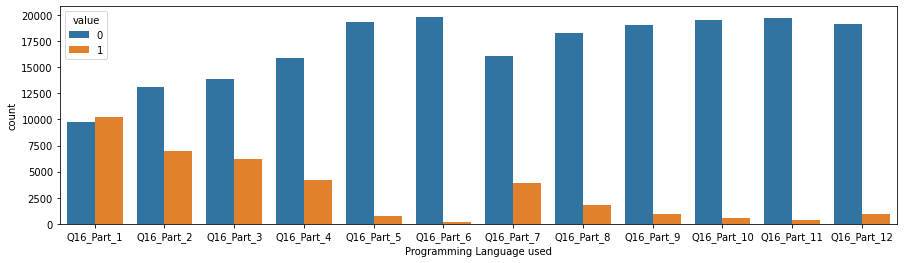

In [ ]:
fig = plt.figure(figsize=(15,4))

#programming language used
df = pd.melt(responses_oh[["Q16_Part_{}".format(i) for i in [1,2,3,4,5,6,7,8,9,10,11,12]]])
sns.countplot(data=df.loc[df['value']!="NO"], x='variable', hue='value')
plt.xlabel('Programming Language used')

Above graph plots different programming languages used by professionals/students on a regular basis. From the graph we can understand that Python is used most on a regualr basis with a count of 15000 and SQL is on second position with a count of 7500. Julia and Shift are the least used programming languages used by ML, DS engineers.





Text(0.5, 0, 'Specialized Hardware')

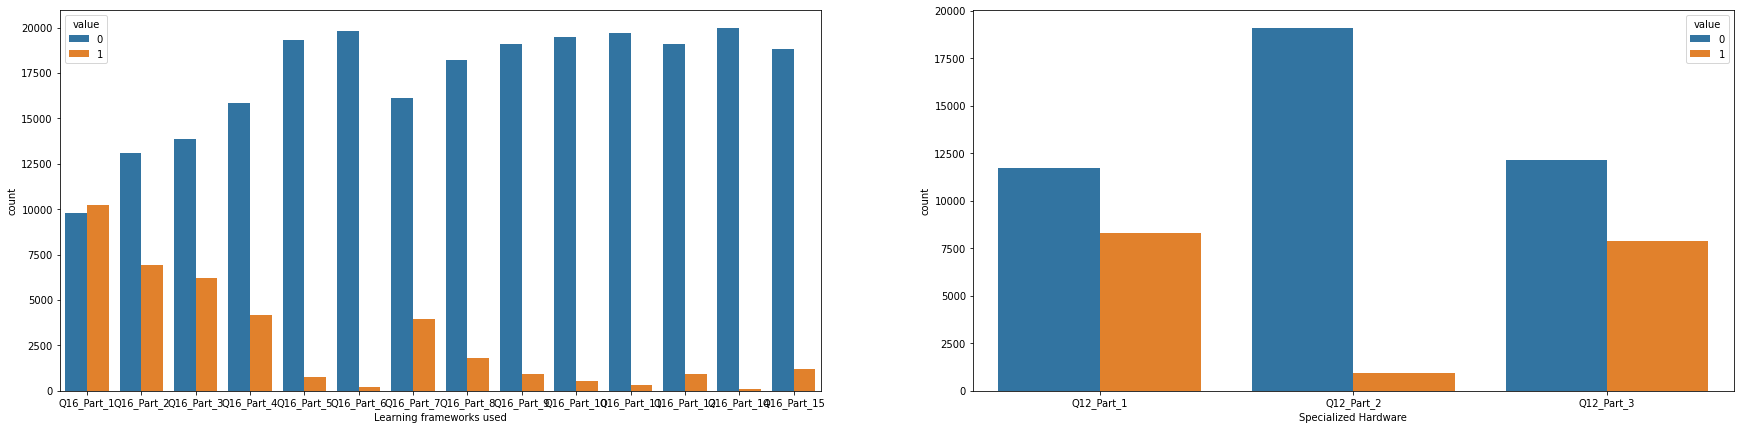

In [ ]:
fig = plt.figure(figsize=(30,7))

#learning frameworks used
plt.subplot(1,2,1)
df = pd.melt(responses_oh[["Q16_Part_{}".format(i) for i in [1,2,3,4,5,6,7,8,9,10,11,12,14,15]]])
sns.countplot(data=df.loc[df['value']!="NO"], x='variable', hue='value')
plt.xlabel('Learning frameworks used')

#learning frameworks used
plt.subplot(1,2,2)
df = pd.melt(responses_oh[["Q12_Part_{}".format(i) for i in [1,2,3]]])
sns.countplot(data=df.loc[df['value']!="NO"], x='variable', hue='value')
plt.xlabel('Specialized Hardware')

Above graph-1 plots different learning frameworks used by professionals/students on a regular basis. From the graph-1 we can understand that Scikit-learn is used most on a regualr basis with a count of 7500 and Tensorflow is on second position with a count of 7300 approx. JAX and MXNet are the least used learning frameworks by ML, DS engineers.

From graph-2 we can understand that quite a few people are intrested into GPUs and using that H/w on a regular basis. 

Text(0.5, 0, 'Automated ML tools/methods')

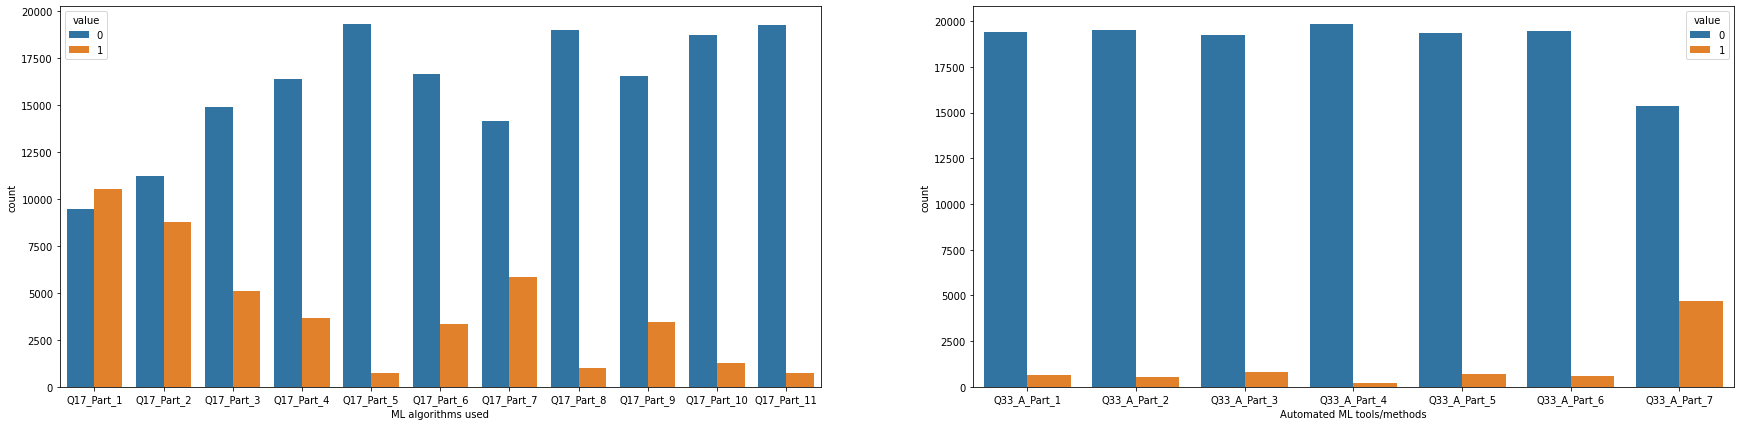

In [ ]:
fig = plt.figure(figsize=(30,7))

#ML algo used
plt.subplot(1,2,1)
df = pd.melt(responses_oh[["Q17_Part_{}".format(i) for i in [1,2,3,4,5,6,7,8,9,10,11]]])
sns.countplot(data=df.loc[df['value']!="NO"], x='variable', hue='value')
plt.xlabel('ML algorithms used')

#Automated ML tools/methods used
plt.subplot(1,2,2)
df = pd.melt(responses_oh[["Q33_A_Part_{}".format(i) for i in [1,2,3,4,5,6,7]]])
sns.countplot(data=df.loc[df['value']!="NO"], x='variable', hue='value')
plt.xlabel('Automated ML tools/methods')

Above graph-1 plots different ML algorithms used by professionals/students on a regualr basis. From the graph-1 we can understand that linear-logistic regression is used most on a regular basis with a count of 10000 and Decision trees are on the second position with a count of 8250 approx. Evolutionary approches and GAN are the least used ML algos by ML, DS engineers.

But from the above graph graph we can also understand that almost 50% people don't really use any previous algo, maybe they write their algo from scrach so to get better results and neither they are into automated ML algo/methods.





Text(0.5, 0, 'NLP Methods')

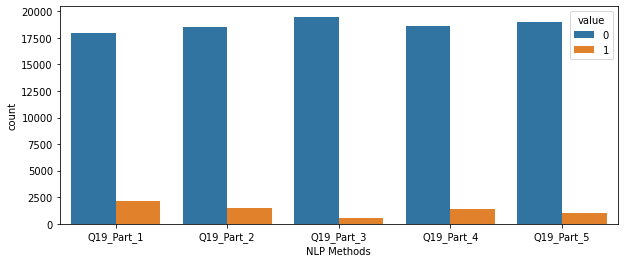

In [ ]:
#NLP methods used
fig = plt.figure(figsize=(10,4))

df = pd.melt(responses_oh[["Q19_Part_{}".format(i) for i in [1,2,3,4,5]]])
sns.countplot(data=df.loc[df['value']!="NO"], x='variable', hue='value')
plt.xlabel('NLP Methods')

Above graph plots different NLP methods used by professionals. But it seems out ML, DS engineers don't really use NLP methods. There are a minority of people who use NLP methods on a regular basis. 

Text(0.5, 0, 'Big data products')

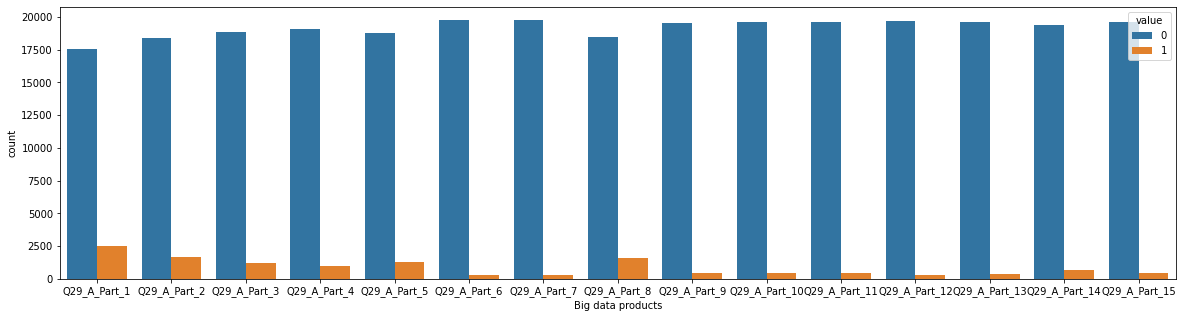

In [ ]:
#big data products used
fig = plt.figure(figsize=(20,5))

df = pd.melt(responses_oh[["Q29_A_Part_{}".format(i) for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]]])
sns.countplot(data=df.loc[df['value']!="NO"], x='variable', hue='value')
plt.xlabel('Big data products')

According to the data, majority of machine learning and data science enthusiasts are using Python as their programming language, Scikit-learn as their learning framework and quite a few are using linear-logistic regression as their ML algo or they are into developing their own algo from scratch.   

ML, DS Engineers are hoping to gain more experience with  Big Data, NLP and compute vision soon. They haven't explored automated Ml tools and methods yet so probably in future they might. 


## Dimensionality reduction


Our ultimate goal is to gain deeper insight by clustering the respondents into "cohorts", and then looking at the state of machine learning and data science as described by each cohort separately.

Because of the dimensionality of the data (hundreds of columns), it will not work very well with K-means clustering. K-means clustering also suffers from the curse of dimensionality: high dimensional data is often very sparse in the overall feature space, so that "closest" cluster mean to a particular sample may not really be much closer than the other cluster means.

Also, since K-means clustering involves distance computations, it is expensive to apply to high-dimensional data.

Finally, we want to be able to visually explore the data and the clusters, and it is very difficult to do this in hundreds of dimensions!

To address this, we'll reduce the dimension of the data to 3D. This will help with clustering, and will also make it easier to visualize the data.

### PCA

The "classic" dimensionality reduction method is PCA. Let's try to apply PCA to this data.

#### To do 2: Apply PCA

In the following cell, use the `sklearn` implementation of PCA. Create a PCA instance in a variable called `pca_reducer`, with `n_components = 3`. Then, fit it using the `responses_oh` data. Finally, use the `transform` method to project the `responses_oh` data into the 3D feature space learned by PCA. Save the result in a variable called `pca_responses`.

In [ ]:
# TODO 2
pca_reducer = PCA(n_components=3).fit(responses_oh)
pca_responses = pca_reducer.transform(responses_oh)

Verify that the `pca_responses` dataset has reduced dimensionality:

In [ ]:
pca_responses.shape

(20036, 3)

Let's visualize this result in 3D to see if it will make clustering easier:

In [ ]:
def plot_3D(elev=20, azim=20, pca_responses=pca_responses):

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    ax.scatter3D(pca_responses[:,0], pca_responses[:,1], pca_responses[:,2], s=0.2);

    ax.view_init(elev=elev, azim=azim)


interact(plot_3D, elev=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         azim=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         pca_responses=fixed(pca_responses));

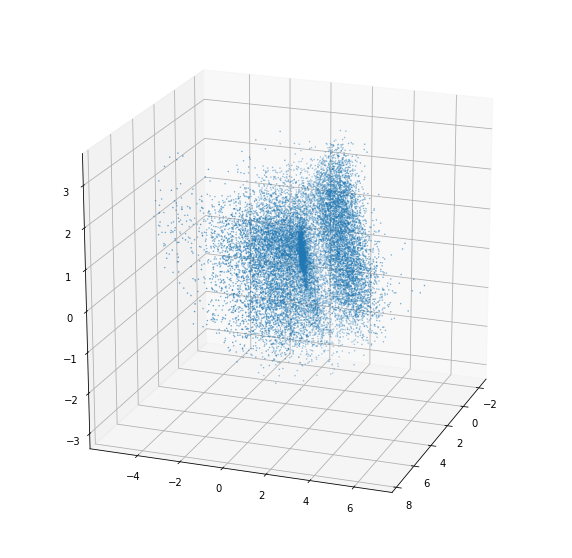

In [ ]:
plot_3D()

Use the elevation and azimuth sliders to view the data from different perspectives.

### UMAP

A more recent approach called UMAP is known to often produce better results for dimensionality reduction for visualization or clustering. 

Here are some useful resources for learning about UMAP:

* [Understanding UMAP](https://pair-code.github.io/understanding-umap/)
* [How UMAP works](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)



Let's try it! We can use `UMAP` in exactly the same way that we used `PCA` - specify the number of components as 3, fit the model using the `responses_oh` data, and then use the fitted model to transform the data.

In [ ]:
umap_reducer = UMAP(n_components=3).fit(responses_oh)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
umap_responses = umap_reducer.transform(responses_oh)

Verify that the `umap_responses` dataset has reduced dimensionality:

In [ ]:
umap_responses.shape

(20036, 3)

And let's plot this version of the data, too:

In [ ]:
def plot_3D(elev=20, azim=20, umap_responses=umap_responses):

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    ax.scatter3D(umap_responses[:,0], umap_responses[:,1], umap_responses[:,2], s=0.2);

    ax.view_init(elev=elev, azim=azim)


interact(plot_3D, elev=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         azim=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         umap_responses=fixed(umap_responses));

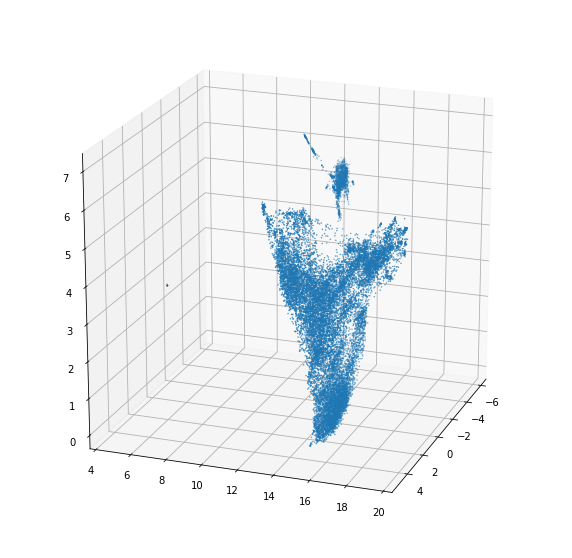

In [ ]:
plot_3D()

Use the elevation and azimuth sliders to view the data from different perspectives.

Which transformation of the data seems more useful for clustering?

**Ans:** UMAP transformation of the data seems more useful for clustering because it has captured global structure very well in the plots above and is giving out meaningful results. One can actually spot different clusters in UMAP and not in PCA for this particular dataset. This could be because UMAP captures non-linear data fitting well in comparison to PCA which captures linear data fitting well. 

## Clustering

Next, let's use a clustering algorithm to try and define distinct "cohorts" among the respondents.


#### To do 3: apply a clustering algorithm

Use a clustering algorithm from `sklearn` to find cohorts in the data. The following design choices are up to you:

* You can apply the clustering to `pca_responses` or to `umap_responses` - whichever you think is most useful for clustering.
* You can use `KMeans` or [any other clustering method](https://scikit-learn.org/stable/modules/clustering.html) implemented in `sklearn`. 
* You can decide how to initialize the cluster centers. Read the function documentation to learn about the initialization options available in the method you have chosen.
* You can choose how many clusters to find, but you must have at least 3 clusters. Save the number of clusters in a variable called `n_clusters`.

Save the cluster labels learned by your model in a variable called `c_responses`, and save the list of cluster centers in `c_centers`.

In [ ]:
# TODO 3

n_clusters = 4
kmeans = KMeans(n_clusters)
clusters = kmeans.fit_predict(umap_responses)
kmeans.cluster_centers_.shape

(4, 3)

5 clusters in 3 dimentions.

In [ ]:
c_centers = kmeans.cluster_centers_
print(c_centers)

[[ 2.7918425 15.783549   1.2637806]
 [ 3.6667635 14.706063   4.1197906]
 [-4.1464114 12.746304   5.3776703]
 [ 1.4939854 16.773697   4.205223 ]]


In [ ]:
c_responses = kmeans.labels_
print(c_responses)

[1 0 3 ... 3 1 1]


Let's visualize the results.

If you used the PCA-transformed data, use this function to visualize the results:

In [ ]:
def plot_3D(elev=20, azim=20, pca_responses=pca_responses, n_clusters=n_clusters,
            c_responses=c_responses, c_centers=c_centers):

    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection='3d')

    cmap = plt.cm.Dark2
    norm = colors.BoundaryNorm(np.arange(0, n_clusters+1, 1), cmap.N)

    p = ax.scatter3D(pca_responses[:,0], pca_responses[:,1], pca_responses[:,2], 
                 c=c_responses, s=0.2, alpha=0.4, cmap=cmap, norm=norm);
    fig.colorbar(p)
    # note: you can adjust the value of s here to change the size of the cluster centers
    p = ax.scatter3D(c_centers[:,0], c_centers[:,1], c_centers[:,2], edgecolor='black',
                 c=range(n_clusters), s=100, cmap=cmap, norm=norm);

    ax.view_init(elev=elev, azim=azim)


interact(plot_3D, elev=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         azim=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         pca_responses=fixed(pca_responses),  n_clusters=fixed(n_clusters),
         c_responses=fixed(c_responses), c_centers=fixed(c_centers));

If you used the UMAP-transformed data, use this function to visualize the results:

In [ ]:
def plot_3Db(elev=20, azim=20, umap_responses=umap_responses, n_clusters=n_clusters,
            c_responses=c_responses, c_centers=c_centers):

    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection='3d')

    cmap = plt.cm.Dark2
    norm = colors.BoundaryNorm(np.arange(0, n_clusters+1, 1), cmap.N)

    p = ax.scatter3D(umap_responses[:,0], umap_responses[:,1], umap_responses[:,2], 
                 c=c_responses, s=0.2, alpha=0.4, cmap=cmap, norm=norm);
    fig.colorbar(p)
    # note: you can adjust the value of s here to change the size of the cluster centers
    p = ax.scatter3D(c_centers[:,0], c_centers[:,1], c_centers[:,2], edgecolor='black',
                 c=range(n_clusters), s=100, cmap=cmap, norm=norm);

    ax.view_init(elev=elev, azim=azim)


interact(plot_3D, elev=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         azim=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         umap_responses=fixed(umap_responses),  n_clusters=fixed(n_clusters),
         c_responses=fixed(c_responses), c_centers=fixed(c_centers));

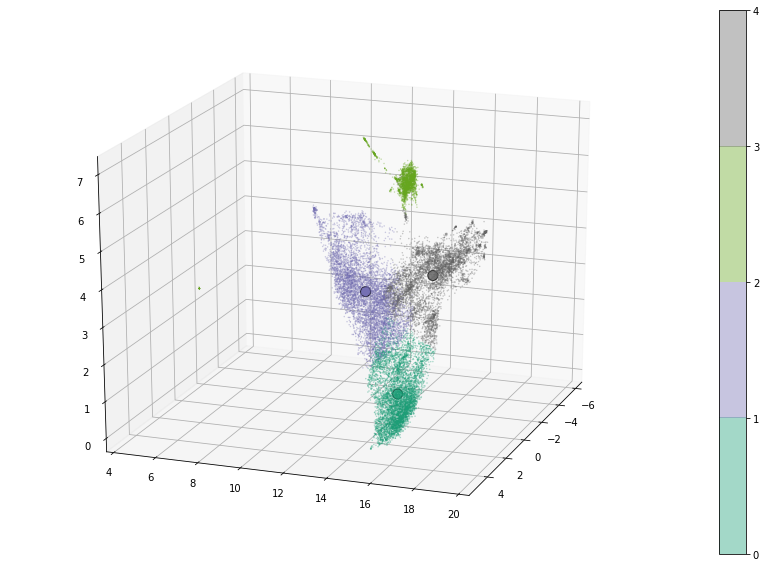

In [ ]:
plot_3Db()

Are you satisfied with your clusters? Do the cluster centers look like a good representation of the samples in the cluster?


**Ans:** Yes, I'm satisfied with the clustering above with respect to the number of clusters that I have chosen i.e. 4. And the cluster centers too look like a good representation of the samples in the cluster. 

Having more number of clusters will not help us to point out similarities between the members and interpret rather complicat things. 

Adjust your clustering (you can change the intialization, the number of clusters, or the clustering algorithm) until you are satisfied with the results.

### To do 4: Apply inverse transform to the cluster centers

Next, we'll look at the cluster centers in the original high-dimensional feature space. 

Use the `inverse_transform` method of your reducer (either the `pca_reducer` or the `umap_reducer`, depending on which type of transformed data you used for clustering). Apply this to the `c_centers` variable to get the cluster centers in the original high-dimensional feature space. Save the result in `c_centers_highd`.

In [ ]:
c_centers_highd = umap_reducer.inverse_transform(c_centers)
c_centers_highd

array([[ 0.9299187 ,  0.17098087,  0.4829456 , ...,  0.0887107 ,
        -0.09102318,  0.08834988],
       [ 1.1396092 ,  0.11668757,  0.33767778, ..., -0.11641815,
         0.24553497, -0.13353056],
       [ 0.03758698, -0.01769327,  0.03803354, ...,  0.01780389,
        -0.01675327, -0.01685685],
       [ 0.99527705,  0.0273927 ,  0.01496295, ..., -0.01413518,
         0.00555631,  0.0053418 ]], dtype=float32)

In [ ]:
c_centers_highd.shape

(4, 336)

Now, we can look at the cluster centers in the high dimensional feature space to see what the "typical" survey answers are for each cluster.

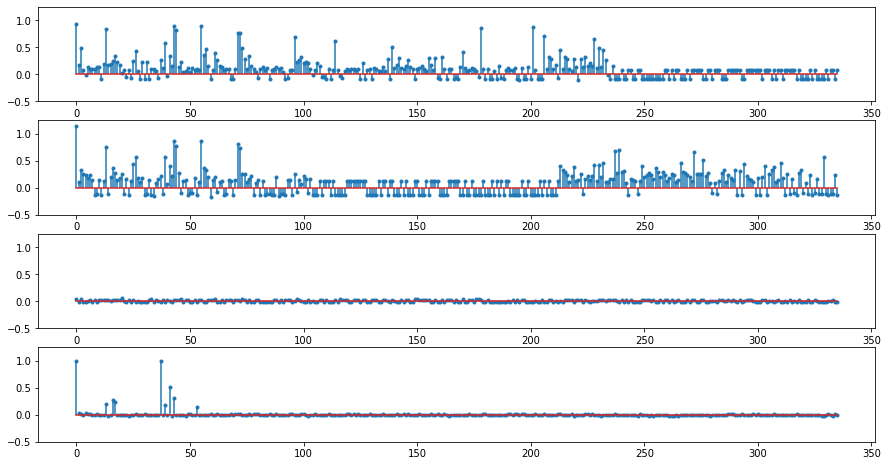

In [ ]:
plt.figure(figsize=(15,n_clusters*2))
for i, c in enumerate(c_centers_highd):
  plt.subplot(n_clusters,1,i+1)
  plt.stem(c, use_line_collection=True, markerfmt='.');
  plt.ylim(-0.5, 1.25) # adjust this as needed to display the data

A value close to 0 for a particular feature means that most respondents in the cluster did *not* select that option. A value close to 1 for a feature means that most respondents in the cluster *did* select that option.

## Cohort analysis

#### To do 5: use the cluster centers in high dimension feature space to explore cohorts



Use the `c_centers_highd`, the cluster labels `c_responses`, and the original data (either `responses`, `responses_sub`, or `responses_oh`) to explore *each cluster* in greater detail.

For each cluster, see if you can identify:

* What do members of the cluster tend to have in common?

**Ans:** 

Cluster 1, 2: In both of these clusters, we can observe, most of the people who were surveyed were professionals, ML, DS engineers as they have responded to the questions well. These set of people have their choice of language, framework, database etc that's why some features have high value and some don't. 

Cluster 3: In this cluster, people aren't actually intrested in ML, DS because all the features have a value equal to zero. There's a possibiltiy that these set of people were students, software/ mobile developers and weren't actually into ML, DS.  

Cluster 4: There are only a small set of people in this cluster which are intrested in ML, DS. Observing feature 1 having the value of 1 means these set of people prefer Python language over any other language. 


* What do members of the cluster say about the state of machine learning and data science? What tools and techniques do they often use? What are they hoping to use?

**Ans:** 

Cluster 1: In this cluster, high value of each feature can be seen for the starting features(0-200) which means these set of people are into core ML and have their choice of framework, IDE, Hardware prefrence, ML algo, etc but they aren't much into ML applications like Big Data, Automated tools and methods, Business Intelligence, Computer Vision, etc. 

Cluster 2: These set of people are quite unique. They are into core ML and have their choice of language, ML algo, etc because of high values of features. They are also exploring ML applications like Big Data, Computer Vision, Cloud Computing and automated tools for ML beacuse a sufficient amount of people answered for these features and have their prefrences.  

Cluster 3: These people are not at all into ML, DS, Haven't explored it also. 

Cluster 4: Only a few percentage of people in this cluster are into ML and are exploring it. They haven't shifted themselves to ML applications and automated tools.


* Is the cluster center a good representation of the cluster members?

**Ans:** Yes, we can observe this from the cosine distance between data points and cluster center. (Coded below) Cluster 1, 4 have data point very close the cluster head while cluster 2,3 have data points a bit far from the cluster head. 

Also note any important differences between clusters. 

**Ans:** Most important difference that can be observed that cluster 1, 2 people are into ML and some are exploring other ML applications and are using automated ML tools. Cluster 3, 4 people are not really into ML. Only a few have just started exploring it and are prefering Python language. 

Use this analysis to draw high-level conclusions about the state of machine learning and data science.

Show your analysis (code + output and visualizations) and also summarize your findings in one or more text cells.

At the end, please summarize your findings with a brief description of each "cohort" that you found.

(To help you understand the level of effort expected - this section is worth 4/10 points for this assignment. For full credit, the graders will expect to see an analysis of sufficient detail to justify this point value.)

In [ ]:
#cosine distance
import scipy.spatial.distance as dist

#for cluster center 1
for i in range(336):
   avg1 = 0
   avg1 = avg1 + dist.cosine(c_centers_highd[0,i], c_centers[0])

#for cluster center 2
for i in range(336):
   avg2 = 0
   avg2 = avg2 + dist.cosine(c_centers_highd[1,i], c_centers[1])

#for cluster center 3
for i in range(336):
     avg3 = 0
     avg3 = avg3 + dist.cosine(c_centers_highd[2,i], c_centers[2])

#for cluster center 4
for i in range(336):
     avg4 = 0
     avg4 = avg4 + dist.cosine(c_centers_highd[3,i], c_centers[3])

print("Average cosine distance for cluster 1:", avg1)
print("Average cosine distance for cluster 2:", avg2)
print("Average cosine distance for cluster 3:", avg3)
print("Average cosine distance for cluster 4:", avg4)

Average cosine distance for cluster 1: 0.28760212659835815
Average cosine distance for cluster 2: 1.8268124461174011
Average cosine distance for cluster 3: 1.5587713122367859
Average cosine distance for cluster 4: 0.2524871826171875


From the above average cosine distances we can observe cluster 1,4 have data points very close to cluster head which means all of these members have many features in common. Cluster 2, 3 data points are a a bit from the cluster head therefore not many features are common comparatively. 

No handles with labels found to put in legend.


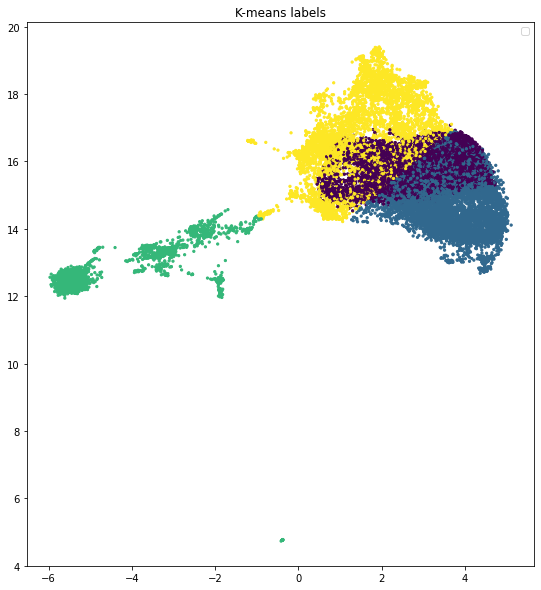

In [ ]:
#comparing actual labels and k-means labels
fig = plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.scatter(x=umap_responses[:,0], y=umap_responses[:,1], c=c_responses, cmap='viridis', s=5);
plt.title("K-means labels")
plt.legend()

Above graph shows umap_responses with labels. We can observe how cluster 3(green) has no feature in common with the other 3 clusters as cluster 3 members aren't intrested in ML much. 